In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams
plt.rcParams['figure.figsize'] = (20,6)
import warnings
warnings.simplefilter(action='ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order
import statsmodels.api as sm
from pmdarima.arima import auto_arima


### Load the data

In [12]:
df_combined=pd.read_pickle('combined.pkl')
df_test=pd.read_pickle('test.pkl')
df_train=pd.read_pickle('train.pkl')

## ARIMA on Train

In [66]:
# This works in a similar fashion to the ar_select_order()
autoarima = auto_arima(df_train['TG'], start_p=0, max_p=3, start_q=0, max_q=3)

In [67]:
autoarima.order

(2, 0, 2)

In [7]:
# Fit an ARIMA model with the above params on the test data
arima_model_train = ARIMA(df_train['TG'],order=(2, 0, 2)).fit()
df_train['AMIRA_pred']=arima_model_train.predict()

<AxesSubplot:xlabel='DATE'>

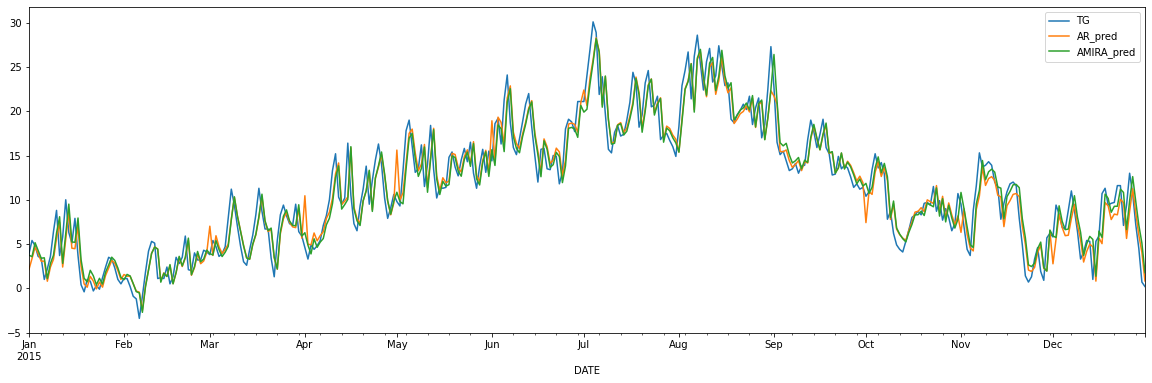

In [8]:
df_train[df_train.index.year==2015][['TG','AR_pred',"AMIRA_pred"]].plot()

In [9]:
print("R2 score ARIMA train   :",r2_score(df_train['TG'], df_train['AMIRA_pred']))

R2 score ARIMA train   : 0.9151652685148932


## ARIMA on Test

In [10]:
# Fit an ARIMA model with the above params on the test data
arima_model = ARIMA(df_test['TG'],order=(2, 0, 2)).fit()


In [11]:
# Look at the summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     TG   No. Observations:                 1827
Model:                     ARMA(2, 2)   Log Likelihood               -3979.631
Method:                       css-mle   S.D. of innovations              2.135
Date:                Sun, 27 Jun 2021   AIC                           7971.261
Time:                        22:55:34   BIC                           8004.324
Sample:                    01-01-2016   HQIC                          7983.457
                         - 12-31-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9700      2.810      3.547      0.000       4.462      15.478
ar.L1.TG       1.5224      0.041     37.526      0.000       1.443       1.602
ar.L2.TG      -0.5257      0.040    -13.142      0.000      -0.604      -0.447
ma.L1.TG      -0.4902      0.040    -12.353      0.000      -0.568      -0.412
ma.L2.TG      -0.3162      0.023    -13.463      0.000      -0.362      -0.270
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0070           +0.0000j            1.0070            0.0000
AR.2            1.8891           +0.0000j            1.8891            0.0000
MA.1            1.1648           +0.0000j            1.1648            0.0000
MA.2           -2.7150           +0.0000j            2.7150            0.5000
-----------------------------------------------------------------------------
"""

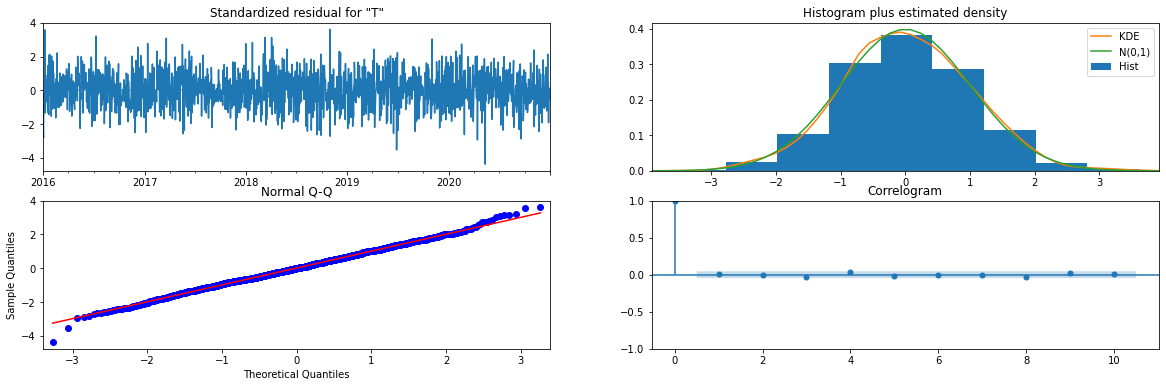

In [46]:
p=arima_model.plot_diagnostics()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. 

In [13]:
df_test['AMIRA_pred']=arima_model.predict()

<AxesSubplot:xlabel='DATE'>

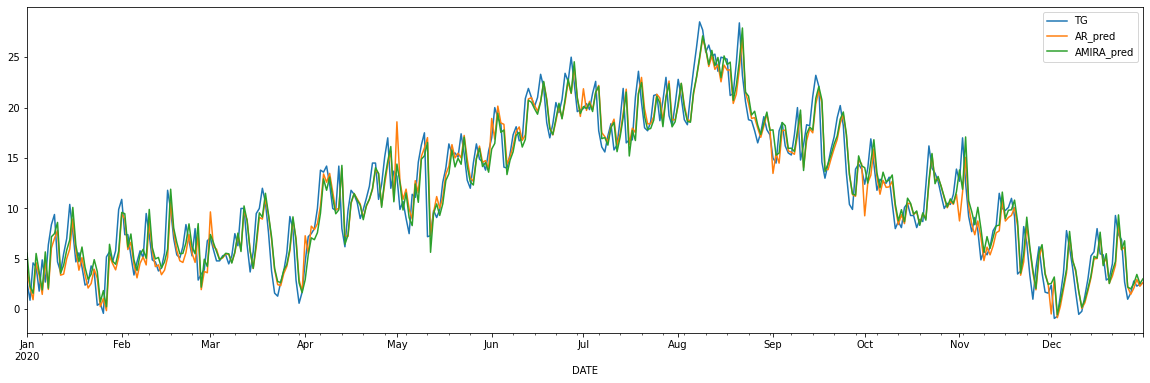

In [14]:
df_test[df_test.index.year==2020][['TG','AR_pred',"AMIRA_pred"]].plot()

In [19]:
# let's check R squared score
print("R2 score Trend+Seasonality Model :",r2_score(df_test['TG'], df_test['seasonal_trend']))
print("R2 score Autoregressive Model    :",r2_score(df_test['TG'], df_test['AR_pred']))
print("R2 score ARIMA                   :",r2_score(df_test['TG'], df_test['AMIRA_pred']))


R2 score Trend+Seasonality Model : 0.7725310108865036
R2 score Autoregressive Model    : 0.9188415604091761
R2 score ARIMA                   : 0.9217104061507946


In [18]:
print("MSE Trend+Seasonality Model :", mean_squared_error(df_test['TG'], df_test['seasonal_trend']))
print("MSE Autoregressive Model    :", mean_squared_error(df_test['TG'], df_test['AR_pred']))
print("MSE score ARIMA             :",mean_squared_error(df_test['TG'], df_test['AMIRA_pred']))

MSE Trend+Seasonality Model : 13.359219584347226
MSE Autoregressive Model    : 4.76642297414802
MSE score ARIMA             : 4.597936094396787


## Apply on the combined Dataset

In [20]:
# Fit an ARIMA model with the above params on the test data
arima_model = ARIMA(df_combined['TG'],order=(2, 0, 2)).fit()

<AxesSubplot:xlabel='DATE'>

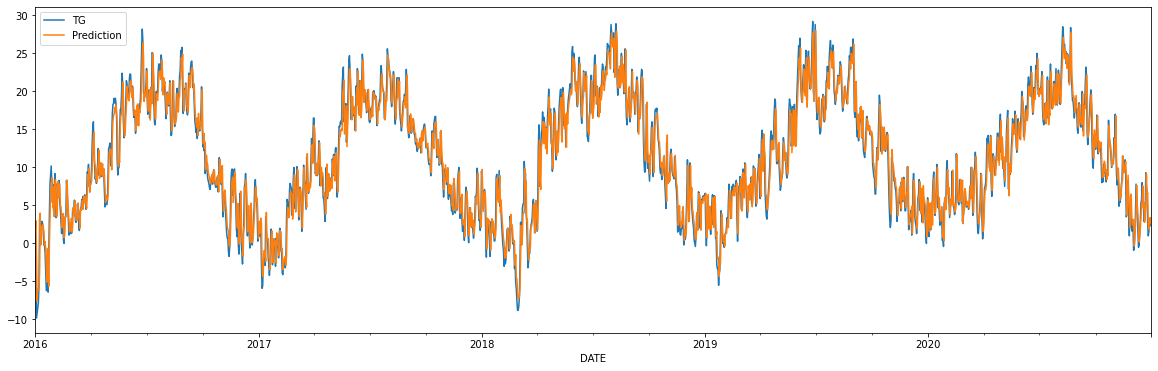

In [26]:

# Get prediction for test set
start = len(df_train)
end = len(df_train) + len(df_test) - 1
# type typ : levels - Predict original endogenous variables
# linear : Linear prediction
prediction = arima_model.predict(start, end, 
                         typ='linear').rename('Prediction')
df_test['TG'].plot(legend=True)
prediction.plot(legend=True)

<AxesSubplot:xlabel='DATE'>

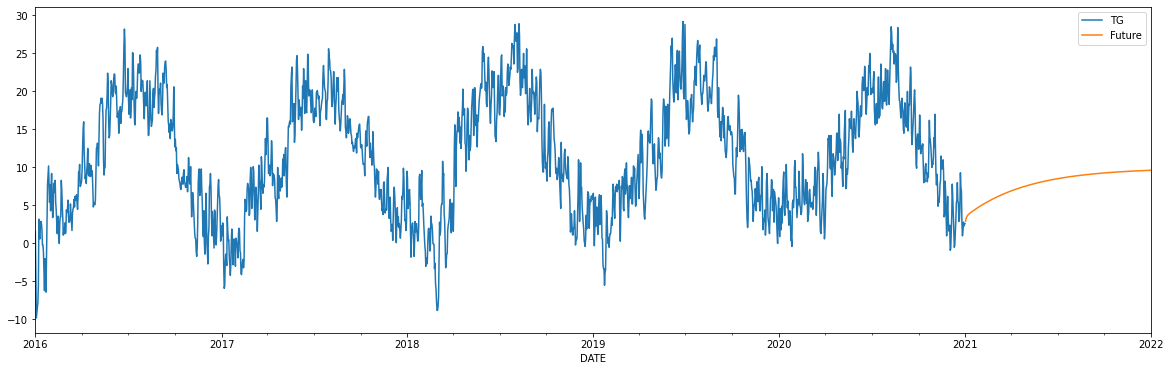

In [25]:

# Predict CO2 levels 1 year into the future

future = arima_model.predict(len(df_combined), len(df_combined)+365, 
                    typ='levels').rename('Future')
df_test['TG'].plot(legend=True)
future.plot(legend=True)

The model seems to give a directionally correct forecast.

## SARIMAX
Kernel crushed numerous times when I tried to find the Order and/or to train Sarimax modelon using the full dataset, so i decided to resample data by month.

In [13]:
df_combined = df_combined.resample(rule='M').mean()# Change frequency to month
df_test=df_test.resample(rule='M').mean()
df_train=df_train.resample(rule='M').mean()

## SARIMAX on Test
Searching fro Sarimax parameters with the following For-loop gave me a better result than using auto-arima. The process took a while(i forced to stop) and the output is quite long. Attached the .png file with the lowest AIC and the corresponding parametr that I ended up using.

![](./search.png)

<AxesSubplot:xlabel='DATE'>

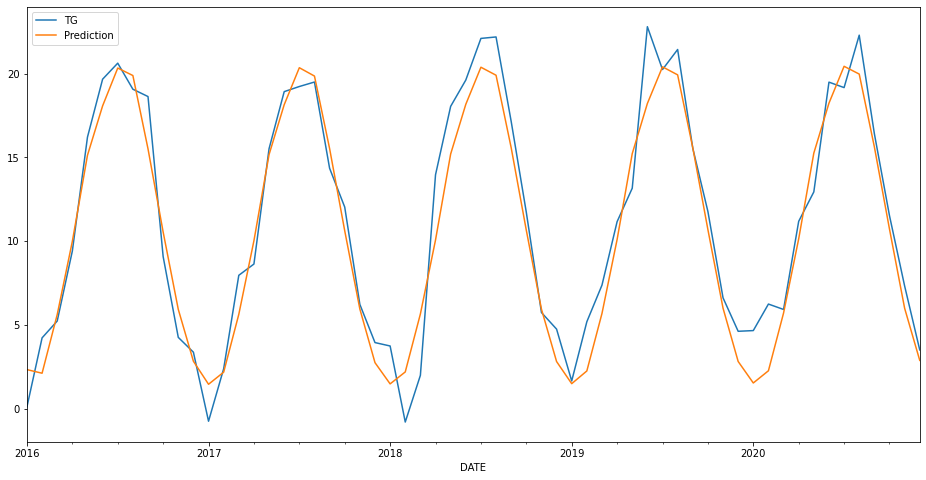

In [14]:
#SARIMA(1, 1, 3)x(1, 1, 3, 12)12    AIC:2109    
model = SARIMAX(df_train['TG'], order=(1, 1,3),
               seasonal_order=(1, 1, 3, 12))
res = model.fit()
# Get prediction for test set
start = len(df_train)
end = len(df_train) + len(df_test) - 1
# type typ : levels - Predict original endogenous variables
# linear : Linear prediction
prediction = res.predict(start, end, 
                         typ='levels').rename('Prediction')
df_test['TG'].plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

In [15]:
print("R2 score SARIMAX                 :",r2_score(df_test['TG'], prediction))
print("MSE score SARIMAX                :",mean_squared_error(df_test['TG'], prediction))

R2 score SARIMAX                 : 0.9294992170153442
MSE score SARIMAX                : 3.4365654854631473


## Predict the future

<AxesSubplot:xlabel='DATE'>

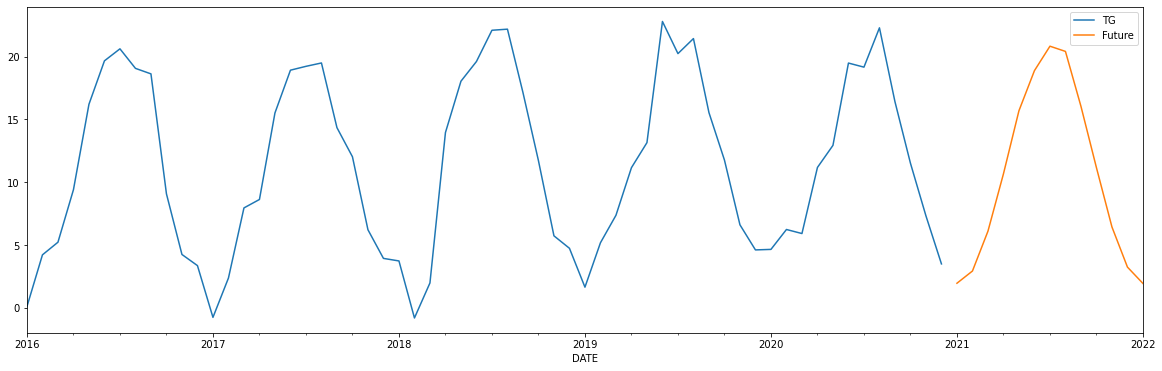

In [16]:
# Predict  1 year into the future
model = SARIMAX(df_combined['TG'], order=(1, 1,3),
               seasonal_order=(1, 1, 3, 12))
res = model.fit()
future = res.predict(len(df_combined), len(df_combined)+12, 
                    typ='levels').rename('Future')
df_test['TG'].plot(legend=True)
future.plot(legend=True)

In [17]:
res.forecast()

2021-01-31    1.96451
Freq: M, dtype: float64

In [18]:
feat=res.predict(len(df_combined), len(df_combined)+11)
feat.to_pickle('feat.pkl')

In [19]:
df_feat=pd.read_pickle('df_feat.pkl')
df_feat=df_feat.resample(rule='M').mean()

<AxesSubplot:xlabel='DATE'>

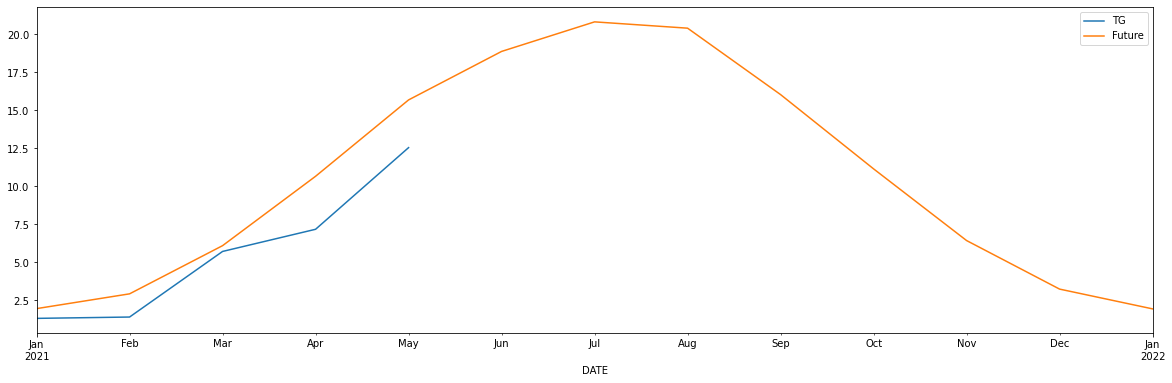

In [21]:
df_feat.plot(legend=True)
future.plot(legend=True)